In [1]:
import ROOT as r
import math
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/00


# 1.0 Define Functions

In [2]:
# global constants
EMMU = 105.6 # mass of muon [MeV] (from PDG)
EMASS = 0.511 # mass of positron [MeV] 
pi = np.pi
twopi = 2*pi
fine_structure_const = 1/137

In [3]:
# radiative correction codes from geant4
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/particles/management/include/G4MuonDecayChannelWithSpin.hh
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/externals/clhep/include/CLHEP/Units/PhysicalConstants.h

def F_c(x,x0,omega):
    f_c =0;
    f_c = (5.+17.*x-34.*x*x)*(omega+np.log(x))-22.*x+34.*x*x;
    f_c = (1.-x)/(3.*x*x)*f_c;
    f_c = (6.-4.*x)*R_c(x,omega)+(6.-6.*x)*np.log(x) + f_c;
    f_c = (fine_structure_const/twopi) * (x*x-x0*x0) * f_c;

    return f_c;

def F_theta(x,x0, omega):
    f_theta=0;

    f_theta = (1.+x+34*x*x)*(omega+np.log(x))+3.-7.*x-32.*x*x;
    f_theta = f_theta + ((4.*(1.-x)*(1.-x))/x)*np.log(1.-x);
    f_theta = (1.-x)/(3.*x*x) * f_theta;
    f_theta = (2.-4.*x)*R_c(x,omega)+(2.-6.*x)*np.log(x)-f_theta;
    f_theta = (fine_structure_const/twopi) * (x*x-x0*x0) * f_theta;

    return f_theta;

def R_c(x,omega):
    n_max = int(100.*x);

    if(n_max<10):n_max=10;

    L2 = 0.0;

    for n in range(n_max+1)[1:]:
        L2 += pow(x,n)/(n*n);

    r_c=0.0;

    r_c = 2.*L2-(pi*pi/3.)-2.;
    r_c = r_c + omega * (1.5+2.*np.log((1.-x)/x));
    r_c = r_c - np.log(x)*(2.*np.log(x)-1.);
    r_c = r_c + (3.*np.log(x)-1.-1./x)*np.log(1.-x);

    return r_c;

In [4]:
def GenerateMichelKinematics():
    #   // code adapted from geant4 
    #   // ***************************************************
    #   //     x0 <= x <= 1.   and   -1 <= y <= 1
    #   //
    #   //     F(x,y) = f(x)*g(x,y);   g(x,y) = 1.+g(x)*y
    #   // ***************************************************

    #   // ***** sampling F(x,y) directly (brute force) *****
    
    # Michel Parameters
    michel_rho   = 0.75 # Standard Model Michel rho
    michel_delta = 0.75 # Standard Model Michel delta
    michel_xsi   = 1.00 # Standard Model Michel xsi
    michel_eta   = 0.00 # Standard Model eta
    
    # kinematic constants of muon decay
    W_mue  = (EMMU*EMMU+EMASS*EMASS)/(2.*EMMU) # shared # gives the maximum energy of emitted positron (52.8 MeV), neglecting neutrino mass
    x0     =  EMASS/W_mue
    x0_squared = x0*x0

    # initialize variables during michel sampling
    MAX_LOOP = 1000 # maximum number of trials (before giving up the guess)
    count = 0
    rndm =0
    x =0
    ctheta =0
    FG = 0
    FG_max = 2.00

    while (count<MAX_LOOP):
        rndm = np.random.uniform(0,1);

        x = x0 + rndm*(1.-x0); # throw out a guess for x

        x_squared = x*x;

        F_IS=0; F_AS=0; G_IS=0; G_AS=0

        F_IS = 1./6.*(-2.*x_squared+3.*x-x0_squared);
        F_AS = 1./6.*np.sqrt(x_squared-x0_squared)*(2.*x-2.+np.sqrt(1.-x0_squared));

        G_IS = 2./9.*(michel_rho-0.75)*(4.*x_squared-3.*x-x0_squared);
        G_IS = G_IS + michel_eta*(1.-x)*x0;

        G_AS = 3.*(michel_xsi-1.)*(1.-x);
        G_AS = G_AS+2.*(michel_xsi*michel_delta-0.75)*(4.*x-4.+np.sqrt(1.-x0_squared));
        G_AS = 1./9.*np.sqrt(x_squared-x0_squared)*G_AS;

        F_IS = F_IS + G_IS;
        F_AS = F_AS + G_AS;

    # / *** Radiative Corrections ***
        omega =  np.log(EMMU/EMASS);
        R_IS = F_c(x,x0,omega);

        F = 6.*F_IS + R_IS/np.sqrt(x_squared-x0_squared);

    # // *** Radiative Corrections ***

        R_AS = F_theta(x,x0,omega);

        rndm = np.random.uniform(0,1);

        ctheta = 2.*rndm-1.; # throw out a guess for theta (cosine of angle between spin and momentum of positron, range from -1 to 1)

        G = 6.*F_AS - R_AS/np.sqrt(x_squared-x0_squared);


    # combine separate parts

        FG = np.sqrt(x_squared-x0_squared)*F*(1.+(G/F)*ctheta);

        if(FG>FG_max):
            Print("JustWarning, Problem in Muon Decay: FG > FG_max");
            FG_max = FG;

        rndm = np.random.uniform(0,1); # throw out a guess for THOR
        count +=1

        if (FG >= rndm*FG_max): # points ?? above ?? the surface of distribution get sampled ?????????????
            return x*W_mue,ctheta
            break

In [5]:
def GeneratePositron_MRF(energy,ctheta,theta_s):
    # https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/externals/clhep/include/CLHEP/Vector/LorentzVector.h
    # get michel x and cos(theta) from the argument
#     energy = x*W_mue
    if(energy < EMASS):energy = EMASS;

    stheta = np.sqrt(1.-ctheta*ctheta);
    
    three_momentum = np.sqrt(energy*energy - EMASS*EMASS);
    
    # generate a random angle phi to fix muon momentum in x,y,z
    rndm = np.random.uniform(0,1) 
    phi = twopi * rndm;
    cphi = np.cos(phi);
    sphi = np.sin(phi);
    
    # momentum of the decay positron with respect to the muon spin
    px0 = stheta*cphi*three_momentum ;
    py0 = stheta*sphi*three_momentum ;
    pz0 = ctheta*three_momentum ;
    
    # calculate spin precession based on input theta_s
    ctheta_s = np.cos(theta_s); # sin(theta_s) # muDecayPolZ i not yet understand, but polarization involve counting, so it is lorentz transformed into itself
    stheta_s = np.sin(theta_s); # cos(theta_s) # muDecayPolX ref: https://arxiv.org/pdf/hep-ph/0409166.pdf
    
    # rotate components px py pz according to spin precession angle theta_s
    px = ctheta_s*px0 + stheta_s*pz0
    py = py0
    pz = -stheta_s*px0 + ctheta_s*pz0
    
    return energy, px, py, pz, stheta_s, ctheta_s # stheta_s is muDecayPolX     # ctheta_s is muDecayPolZ

In [6]:
def Lorentz_Boost(x_0,x_1,x_2,x_3,gamma,beta1,beta2,beta3,inverse=False):
    '''
    Implementation of general lorentz boost, from Jackson (11.98)
    x is a 4-vector, with components x_0, x_1, x_2, x_3 (minkowski notation with 0,1,2,3 represent ct,x,y,z)
    x can be in K or K' frame, the inverse parameter will take care the correct transformation
    beta1, beta2, beta3 are the components of the velocity of the moving frame K' (K and K' axes are taken to be all parallel to each other)
    
    '''

    if(inverse==True):    # invserse transformation from K' back to K (lab), beta changes sign
        beta1 = -beta1
        beta2 = -beta2
        beta3 = -beta3

    beta_squared = (gamma*gamma - 1) / (gamma*gamma)
        
    #calculate all matrix element of the transformation
    B_00 = gamma

    B_01 = -gamma*beta1

    B_02 = -gamma*beta2

    B_03 = -gamma*beta3


    B_10 = -gamma*beta1

    B_11 = 1+(gamma-1)*(beta1*beta1)/(beta_squared)

    B_12 = (gamma-1)*(beta1*beta2)/(beta_squared)

    B_13 = (gamma-1)*(beta1*beta3)/(beta_squared)


    B_20 = -gamma*beta2

    B_21 = (gamma-1)*(beta2*beta1)/(beta_squared)

    B_22 = 1+(gamma-1)*(beta2*beta2)/(beta_squared)

    B_23 = (gamma-1)*(beta2*beta3)/(beta_squared)


    B_30 = -gamma*beta3

    B_31 = (gamma-1)*(beta3*beta1)/(beta_squared)

    B_32 = (gamma-1)*(beta3*beta2)/(beta_squared)

    B_33 = 1+(gamma-1)*(beta3*beta3)/(beta_squared)


    # calculate the results
    x0_transformed = B_00*x_0 + B_01*x_1 + B_02*x_2 + B_03*x_3

    x1_transformed = B_10*x_0 + B_11*x_1 + B_12*x_2 + B_13*x_3

    x2_transformed = B_20*x_0 + B_21*x_1 + B_22*x_2 + B_23*x_3

    x3_transformed = B_30*x_0 + B_31*x_1 + B_32*x_2 + B_33*x_3

    return x0_transformed, x1_transformed, x2_transformed, x3_transformed

In [7]:
def Calculate_Phase(y1, x1, y2, x2):
   # compute the angle difference between vector1 and vector2 given their x,y components. */
   
    ans1 = np.arctan2(y1,x1);  # angle of vector 1, muDecayP
    ans2 = np.arctan2(y2,x2);  # angle of vector 2, muDecayPol
    ans = ans1 - ans2;

    if(ans<0):
        ans = ans+2*np.pi;

    return ans;

In [8]:
def GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c):
    # fixed parameters, lorentz boost parameter (in gm2 experiment)
    p_mu_magic = 3.1 # GeV/c (PRL)
    gamma_mu = 29.3 # (PRL)
    beta_mu_squared = 1-(1/gamma_mu)*(1/gamma_mu) # check the redundancy !
    beta_mu = np.sqrt(beta_mu_squared) # calculated from gamma_mu
    gamma_tau_mu = 64.4e-6 # sec (PRD)

    # calculate cyclotron motion for muon using argument theta_c
    ctheta_c = np.cos(theta_c);
    stheta_c = np.sin(theta_c);

    # calculate the velocity components of muon frame in LAB frame
    #     beta_mu_y = 0
    beta_mu_x = beta_mu*stheta_c
    beta_mu_z = beta_mu*ctheta_c
    

    # calculate the momentum components of the muon 
    # ???? muInitPX or muDecayPX ????
    # problem: how to get momentum from beta ????
    #     muInitPY = gamma_mu*EMMU*beta_mu_y 
    muDecayPX = gamma_mu*EMMU*beta_mu_x
    muDecayPZ = gamma_mu*EMMU*beta_mu_z

    # lorentz boost
    PosiInitE,PosiInitPX,PosiInitPY,PosiInitPZ = Lorentz_Boost(E_primed,px_primed,py_primed,pz_primed,gamma_mu,beta_mu_x,0,beta_mu_z,inverse=True) 
    
    return PosiInitE, PosiInitPX, PosiInitPY, PosiInitPZ, muDecayPX, muDecayPZ

# 2.0 Test the function against the toyMC and gm2ringsim (to check for code bugs)
# Using angles from uniformly distributed random number

In [1]:
import ROOT as r
import math
import numpy as np
import matplotlib.pyplot as plt

from GM2_PositronDecay import GenerateMichelKinematics, GeneratePositron_MRF, Calculate_Phase, GeneratePositron_LAB

# global constants
EMMU = 105.6 # mass of muon [MeV] (from PDG)
EMASS = 0.511 # mass of positron [MeV] 
pi = np.pi
twopi = 2*pi
fine_structure_const = 1/137

Welcome to JupyROOT 6.24/00


In [9]:
# test michel module
N_positrons = 100000
Michel_Samples = np.zeros(shape=(N_positrons,2)) # store samples
W_mue  = (EMMU*EMMU+EMASS*EMASS)/(2.*EMMU)

for i in range(N_positrons):
    Michel_Samples[i] = GenerateMichelKinematics()

Michel_Samples[:,0] = Michel_Samples[:,0]/W_mue 

In [10]:
# test mrf module
four_momenta_mu_frame = np.zeros(shape=(N_positrons,6)) # store posiInitE, posiInitPX, posiInitPY ,posiInitPZ (in MRF),muDecayPolX, muDecayPolZ

for i in range(N_positrons):
    rndm_theta_s = twopi * np.random.uniform(0,1)
    four_momenta_mu_frame[i] = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s=rndm_theta_s)

In [11]:
# putting all together and test
four_momenta_LAB = np.zeros(shape=(N_positrons,10))
# store the following final variables
#     four_momenta_LAB[i,0] = PosiInitE
#     four_momenta_LAB[i,1] = PosiInitPX
#     four_momenta_LAB[i,2] = PosiInitPY
#     four_momenta_LAB[i,3] = PosiInitPZ
#     four_momenta_LAB[i,4] = muDecayPX
#     four_momenta_LAB[i,5] = muDecayPZ
#     four_momenta_LAB[:,6] = four_momenta_mu_frame[:,4] # muDecayPolX
#     four_momenta_LAB[:,7] = four_momenta_mu_frame[:,5] # muDecayPolZ  
#     four_momenta_LAB[i,8] = phase # g2phase
#     four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  

for i in range(N_positrons):
    # get positrons in MRF
    rndm_theta_s = twopi * np.random.uniform(0,1)
    E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),rndm_theta_s)
    
    # get positrons in LAB
    rndm_theta_c = twopi * np.random.uniform(0,1)
    four_momenta_LAB[i,0:6] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, rndm_theta_c)
    four_momenta_LAB[:,6] = muDecayPolX
    four_momenta_LAB[:,7] = muDecayPolZ  
    
    # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
    phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,5],
                            four_momenta_LAB[i,6], four_momenta_LAB[i,7])
    four_momenta_LAB[i,8] = phase # g2phase
    four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  

# 2.1 visualize the output of the modules separately

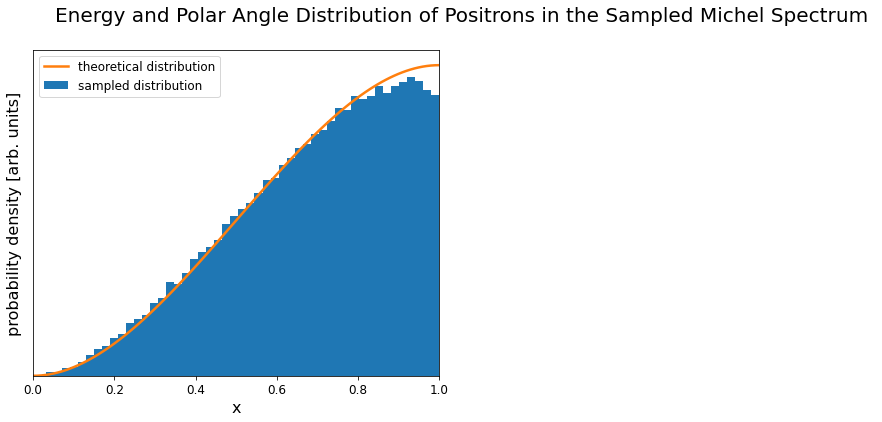

In [12]:
# theoretical calculation, integrated over cos(theta)
x1 = np.zeros(shape=(2,100))
x1[0]=np.linspace(0.0,1.0,100)

y1 = lambda x:(3-2*x)*x*x # IntroductoryMuonScience-Nagamine p.12
x1[1] = y1(x1[0])
x1[1] = x1[1]/np.mean(x1[1]) # dividing a distribution with its mean is p.d.f

# theoretical calculation, integrated over x
x2 = np.zeros(shape=(2,100))
x2[0]=np.linspace(-1.0,1.0,100)

y2 = lambda x:1 + x/3
x2[1] = y2(x2[0])
# x2[1] = x2[1]/np.mean(x2[1]) # dividing a distribution with its mean is p.d.f

plt.rcParams['text.usetex'] = False # enable latex rendering
fig = plt.figure(figsize=(16,6))
fig.suptitle('Energy and Polar Angle Distribution of Positrons in the Sampled Michel Spectrum ', fontsize=20)

ax1 = fig.add_subplot(1,2,1)
ax1.hist(Michel_Samples[:,0],bins=50,density=True, stacked=True,label='sampled distribution') # density:normalized
ax1.plot(x1[0],x1[1],linewidth=2.5,label='theoretical distribution')
ax1.set_xlim([0,1])
ax1.set_yticklabels([])
ax1.set_xlabel('x',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)
ax1.legend(fontsize=12)

In [13]:
# load musrSim data
df = r.RDataFrame("t1",'../dev/musr_10Mv2.root')
df = df.Define("posiInitE","sqrt(posIniMomX*posIniMomX + posIniMomY*posIniMomY + posIniMomZ*posIniMomZ - 0.511*0.511)")
musrSim_dict = df.AsNumpy()

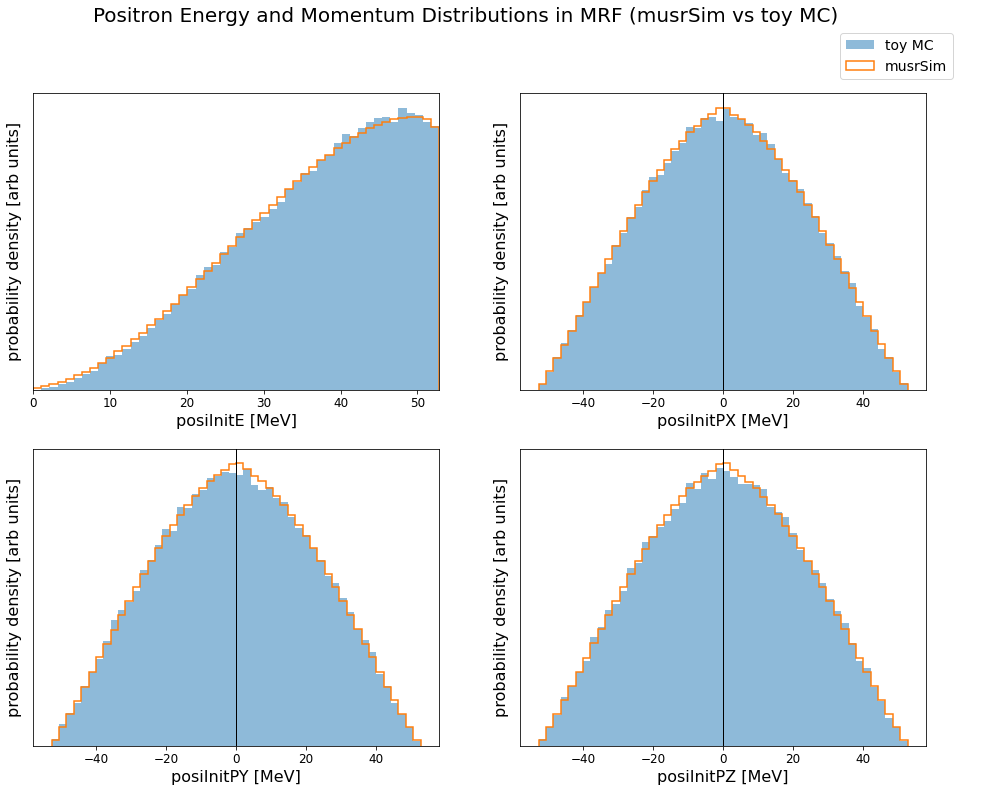

In [14]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in MRF (musrSim vs toy MC)', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.hist(four_momenta_mu_frame[:,0],range=(0,52.8),bins=50,density=True,alpha=0.5,label='toy MC')
ax1.hist(musrSim_dict['posiInitE'],range=(0,52.8),bins=50,density=True,histtype='step',linewidth=1.5,label='musrSim')
ax1.set_xlim([0,52.8])
ax1.set_yticklabels([])
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb units]",fontsize=16)


ax2 = fig.add_subplot(2,2,2)
ax2.hist(four_momenta_mu_frame[:,1],range=(-52.8,52.8),bins=50,density=True,alpha=0.5)
ax2.hist(musrSim_dict['posIniMomX'],range=(-52.8,52.8),bins=50,density=True,histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', left=False)
ax2.tick_params(axis='x', labelsize=12)
ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb units]",fontsize=16)


ax3 = fig.add_subplot(2,2,3)
ax3.hist(four_momenta_mu_frame[:,2],range=(-52.8,52.8),bins=50,density=True,alpha=0.5)
ax3.hist(musrSim_dict['posIniMomY'],range=(-52.8,52.8),bins=50,density=True,histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_yticklabels([])
ax3.tick_params(axis='y', left=False)
ax3.tick_params(axis='x', labelsize=12)
ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb units]",fontsize=16)


ax4 = fig.add_subplot(2,2,4)
ax4.hist(four_momenta_mu_frame[:,3],range=(-52.8,52.8),bins=50,density=True,alpha=0.5)
ax4.hist(musrSim_dict['posIniMomZ'],range=(-52.8,52.8),bins=50,density=True,histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_yticklabels([])
ax4.tick_params(axis='y', left=False)
ax4.tick_params(axis='x', labelsize=12)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb units]",fontsize=16)


fig.legend(loc=(0.85,0.9),fontsize=14)

In [15]:
r.gInterpreter.Declare("""
//#include <math.h>

double Phase(double y1, double x1, double y2, double x2) {
   /* compute the angle difference between vector1 and vector2 given their x,y components. */
   
   double ans1 = atan2(y1,x1);  //angle of vector 1, muDecayP
   double ans2 = atan2(y2,x2);  //angle of vector 2, muDecayPol
   double ans = ans1 - ans2;
   
   if(ans<0){
       ans = ans+2*M_PI;
    }
       
   return ans;
}
""")

# load gm2ringsim data
fname = "/home/junkai.ng/junkai.ng/CaloMC/gm2ringsim_muon_gasgun_ana_21378178_1.root"
df = r.RDataFrame("G2PhaseAnalyzer/g2phase",fname)
df = df.Define("g2phase", "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)") 
df = df.Define("cosg2phase", "cos(g2phase)") 
varList = ["posiInitE","posiInitPX","posiInitPY","posiInitPZ","g2phase","cosg2phase"]
data_gm2ringsim = df.AsNumpy(columns=varList)

ReadStreamerInfo, class:string, illegal uid=-2


Warning in <TClass::Init>: no dictionary for class __basic_string_common<true> is available


In [16]:
def LAB_P_E_dist(target_label='toy MC'):
    # make a plot to compare with the toy MC data
    fig = plt.figure(figsize=(16,12))
    fig.suptitle('Positron Energy and Momentum Distributions in LAB frame (gm2ringsim vs {})'.format(target_label), fontsize=20)

    ax1 = fig.add_subplot(2,2,1)
    ax1.hist(four_momenta_LAB[:,0],range=(0,3100),bins=50,density=True,alpha=0.5,label=target_label)
    ax1.hist(data_gm2ringsim['posiInitE'],range=(0,3100),density=True,bins=50,histtype='step',linewidth=1.5,label='gm2ringsim')
    ax1.set_xlim([0,3150])
    ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
    ax1.set_ylabel("probability density [arb. units]",fontsize=16)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', left=False)
    ax1.set_yticklabels([])

    ax2 = fig.add_subplot(2,2,2)
    ax2.hist(four_momenta_LAB[:,1],range=(-3100,3100),bins=50,density=True,alpha=0.5)
    ax2.hist(data_gm2ringsim['posiInitPX'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
    ax2.axvline(color='black', lw=1.0)
    ax2.set_xlabel('posiInitPX [MeV]',fontsize=16)
    ax2.set_ylabel("probability density [arb. units]",fontsize=16)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', left=False)
    ax2.set_yticklabels([])

    ax3 = fig.add_subplot(2,2,3)
    ax3.hist(four_momenta_LAB[:,2],range=(-56,56),bins=50,density=True,alpha=0.5)
    ax3.hist(data_gm2ringsim['posiInitPY'],range=(-56,56),bins=50,density=True,histtype='step',linewidth=1.5)
    ax3.axvline(color='black', lw=1.0)
    ax3.set_xlabel('posiInitPY [MeV]',fontsize=16)
    ax3.set_ylabel("probability density [arb. units]",fontsize=16)
    ax3.tick_params(axis='x', labelsize=12)
    ax3.tick_params(axis='y', left=False)
    ax3.set_yticklabels([])

    ax4 = fig.add_subplot(2,2,4)
    ax4.hist(four_momenta_LAB[:,3],range=(-3100,3100),bins=50,density=True,alpha=0.5)
    ax4.hist(data_gm2ringsim['posiInitPZ'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
    ax4.axvline(color='black', lw=1.0)
    ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
    ax4.set_ylabel("probability density [arb. units]",fontsize=16)
    ax4.tick_params(axis='x', labelsize=12)
    ax4.tick_params(axis='y', left=False)
    ax4.set_yticklabels([])


    fig.legend(loc=(0.85,0.9),fontsize=12)

In [17]:
def EvPhases(target_label='toy MC'):
    # sort out data at different cos(g2phase), for sampled data
    filter1 = np.where(abs(four_momenta_LAB[:,9]-1)<=0.4 ) # ctheta= 1
    filter2 = np.where(abs(four_momenta_LAB[:,9])<=0.4 )   # ctheta= 0
    filter3 = np.where(abs(four_momenta_LAB[:,9]+1)<=0.4 ) # ctheta= -1

    four_momenta_lab_filter_1 = four_momenta_LAB[filter1]
    four_momenta_lab_filter_2 = four_momenta_LAB[filter2]
    four_momenta_lab_filter_3 = four_momenta_LAB[filter3]

    # sort out data at different cos(g2phase), for gm2ringsim data
    data_gm2ringsim_partial = np.zeros(shape=(2,data_gm2ringsim["posiInitE"].size))
    data_gm2ringsim_partial[0] = data_gm2ringsim["posiInitE"]
    data_gm2ringsim_partial[1] = data_gm2ringsim["cosg2phase"]
    data_gm2ringsim_partial = data_gm2ringsim_partial.T

    filter1 = np.where(abs(data_gm2ringsim_partial[:,1]-1)<=0.4 ) # ctheta= 1
    filter2 = np.where(abs(data_gm2ringsim_partial[:,1])<=0.4 )   # ctheta= 0
    filter3 = np.where(abs(data_gm2ringsim_partial[:,1]+1)<=0.4 ) # ctheta= -1

    data_gm2ringsim_partial_filter_1 = data_gm2ringsim_partial[filter1]
    data_gm2ringsim_partial_filter_2 = data_gm2ringsim_partial[filter2]
    data_gm2ringsim_partial_filter_3 = data_gm2ringsim_partial[filter3]

    # make a plot to compare with the toy MC data
    fig = plt.figure(figsize=(12,8))
    fig.suptitle('Positron Energy Distributions at different g2phases (gm2ringsim vs {})'.format(target_label), fontsize=20)

    ax1 = fig.add_subplot(1,1,1)
    ax1.hist(data_gm2ringsim_partial_filter_1[:,0],range=(-3100,3100),bins=60,density=True,color='darkorange',histtype='step',linewidth=1.5)
    bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_1[:,0],range=(-3100,3100),bins=60,density=True)
    bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
    ax1.scatter(bin_midpt,bin_counts,c='#FF7200',label='g2phase=0')

    ax1.hist(data_gm2ringsim_partial_filter_2[:,0],range=(-3100,3100),bins=60,density=True,color='purple',histtype='step',linewidth=1.5)
    bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_2[:,0],range=(-3100,3100),bins=60,density=True)
    bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
    ax1.scatter(bin_midpt,bin_counts,c='#7200FF',label='g2phase=90')

    ax1.hist(data_gm2ringsim_partial_filter_3[:,0],range=(-3100,3100),bins=60,density=True,color='darkgreen',histtype='step',linewidth=1.5)
    bin_counts,bin_edges = np.histogram(four_momenta_lab_filter_3[:,0],range=(-3100,3100),bins=60,density=True)
    bin_midpt = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_counts))]
    ax1.scatter(bin_midpt,bin_counts,c='#00FF72',label='g2phase=180')


    ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
    ax1.set_ylabel("probability density [arb. units]",fontsize=16)
    ax1.set_xlim([0,3150])
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', left=False)
    ax1.set_yticklabels([])

    lgd1 = ax1.legend(fontsize=12)
    ax1.add_artist(lgd1)

    import matplotlib.lines as mlines
    line1 = mlines.Line2D([], [],linewidth=0, color='black', marker='o', markersize=6, label=target_label)
    line2 = mlines.Line2D([], [],linewidth=1.5, color='black', markersize=8, label='gm2ringsim')
    lgd2 = ax1.legend(handles=[line1,line2],fontsize=12,loc=(0.1,0.2))
    ax1.add_artist(lgd2)

In [18]:
def EvPhase(title='Energy vs g2phase Distribution (toy MC result)'):
    fig = plt.figure(figsize=(12,8))
    fig.suptitle(title, fontsize=20)

    ax1 = fig.add_subplot(1,1,1)
    ax1.hist2d(four_momenta_LAB[:,8],four_momenta_LAB[:,0],bins=(35,35),density=True,cmap='viridis')

    ax1.set_xlabel('g2phase [rad]',fontsize=16)
    ax1.set_ylabel("posiInitE [MeV]",fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

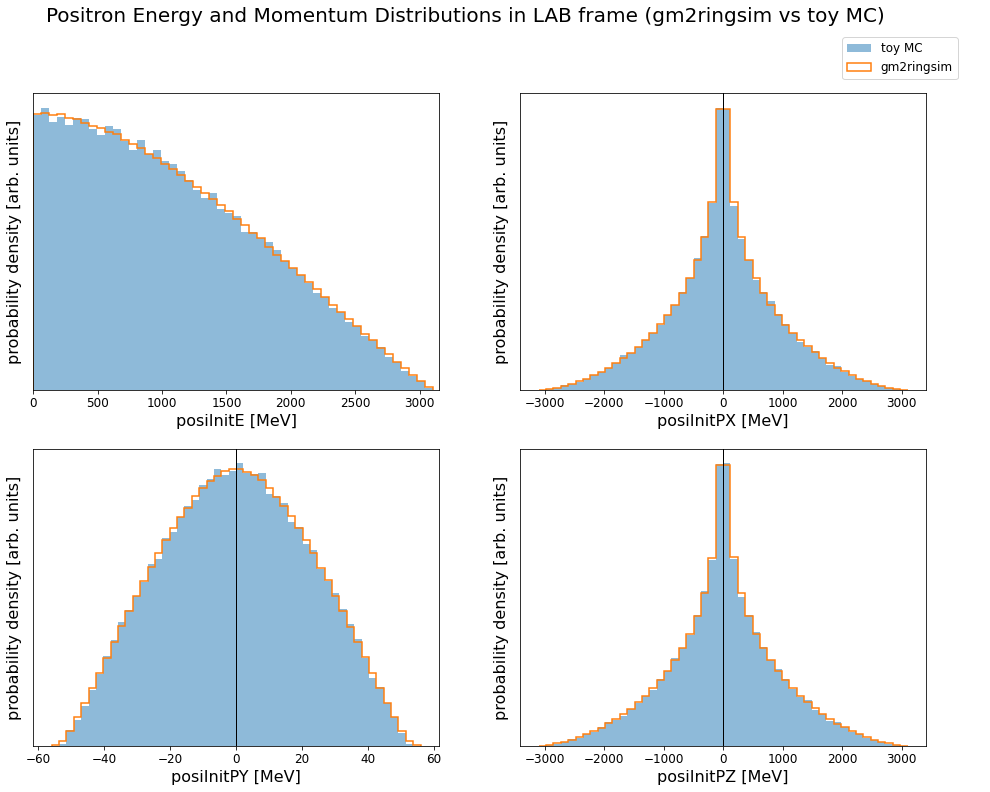

In [19]:
LAB_P_E_dist(target_label='toy MC')

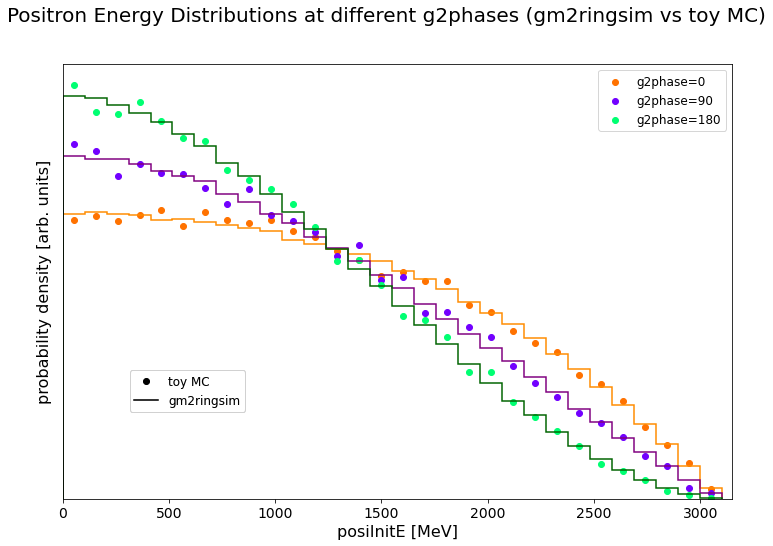

In [20]:
EvPhases(target_label='toy MC')

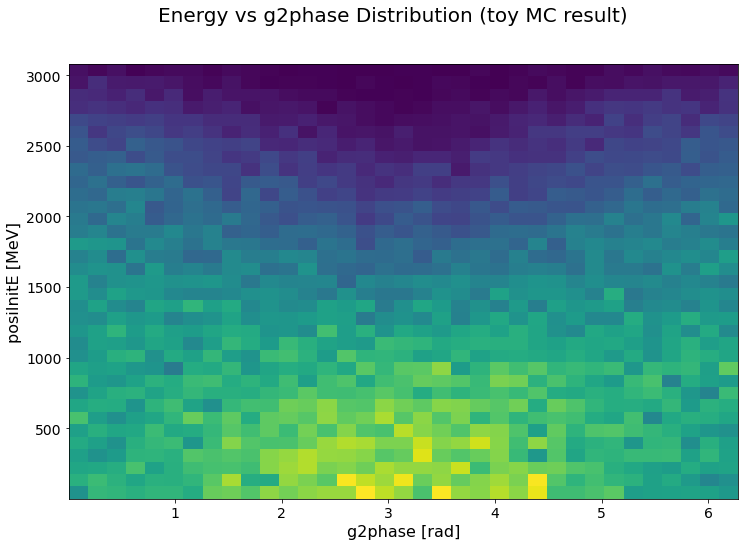

In [21]:
EvPhase(title='Energy vs g2phase Distribution (toy MC result)')

# 3.0 Test with simple beam and spin dynamics

In [22]:
# for more complete bd, pls go to
# https://cdcvs.fnal.gov/redmine/projects/gm2ringsim/repository/revisions/develop/entry/actions/PGA/GasGunBdyn/GasGunBdyn_service.cc
# cyclotron period 0.2291 MHz (149.2 ns ~ 0.1 us)
# spin precession frequency = 6.9315 MHz (0.1443 us)
# data from E989 Note 205: The Beam Dynamics Model (Sweigart)

get_theta_c = lambda t:2*np.pi/0.1492*t # cyclotron motion, phase set to 0
get_theta_s = lambda t:2*np.pi/0.1443*t # spin precession, phase set to 0

N_pts = int(700/0.1)

cyclotron_angles = get_theta_c(np.arange(N_pts))
precession_angles = get_theta_s(np.arange(N_pts))

In [23]:
def GenerateFill(j):
    j = j+1
    print ("Fill: ",j) # this is the relic when testing multiprocessing.pool
    
    four_momenta_LAB = np.zeros(shape=(N_pts,10))

    for i in range(N_pts):
        # positrons in MRF
        theta_s = precession_angles[i]
        E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s)
        
        # boost to LAB frame
        theta_c = cyclotron_angles[i]
        four_momenta_LAB[i,0:6] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c)
        four_momenta_LAB[:,6] = muDecayPolX
        four_momenta_LAB[:,7] = muDecayPolZ  

        # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
        phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,5],
                                four_momenta_LAB[i,6], four_momenta_LAB[i,7])
        four_momenta_LAB[i,8] = phase # g2phase
        four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  
    
    return four_momenta_LAB

In [24]:
fills = [GenerateFill(j) for j in range(20)]

# collect all the fills together
four_momenta_LAB = fills[0]
for i in range(len(fills)-1):
    four_momenta_LAB = np.concatenate((four_momenta_LAB,fills[i+1]))

Fill:  1
Fill:  2
Fill:  3
Fill:  4
Fill:  5
Fill:  6
Fill:  7
Fill:  8
Fill:  9
Fill:  10
Fill:  11
Fill:  12
Fill:  13
Fill:  14
Fill:  15
Fill:  16
Fill:  17
Fill:  18
Fill:  19
Fill:  20


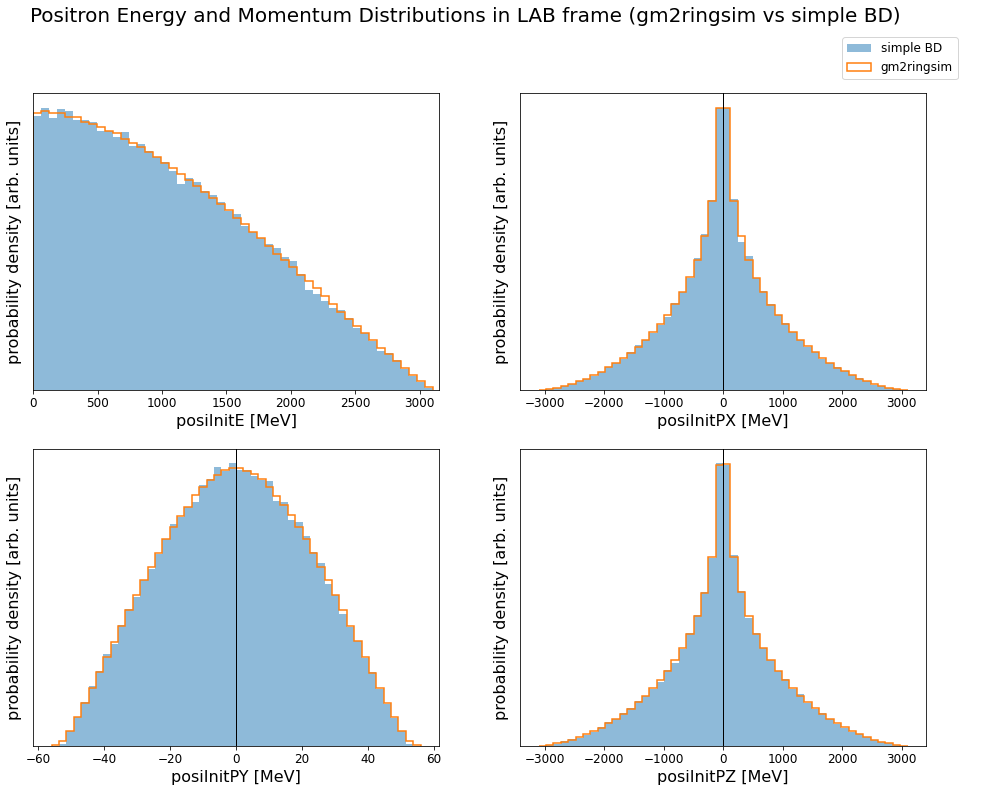

In [25]:
LAB_P_E_dist(target_label='simple BD')

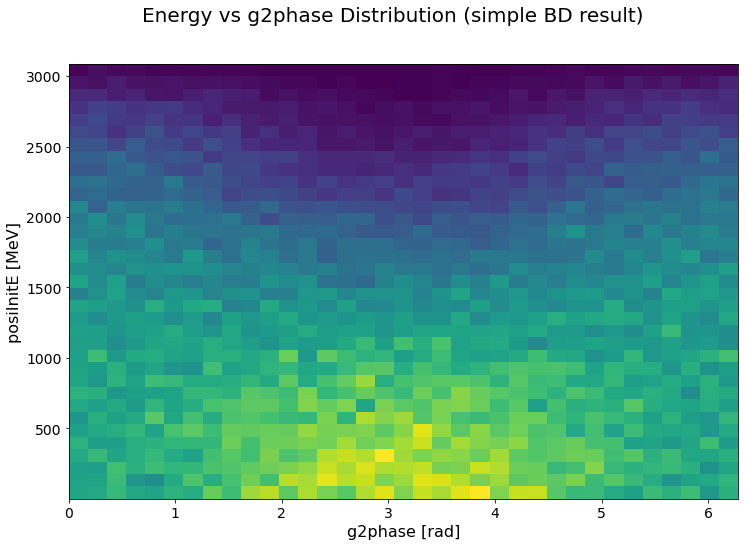

In [26]:
EvPhase(title='Energy vs g2phase Distribution (simple BD result)')

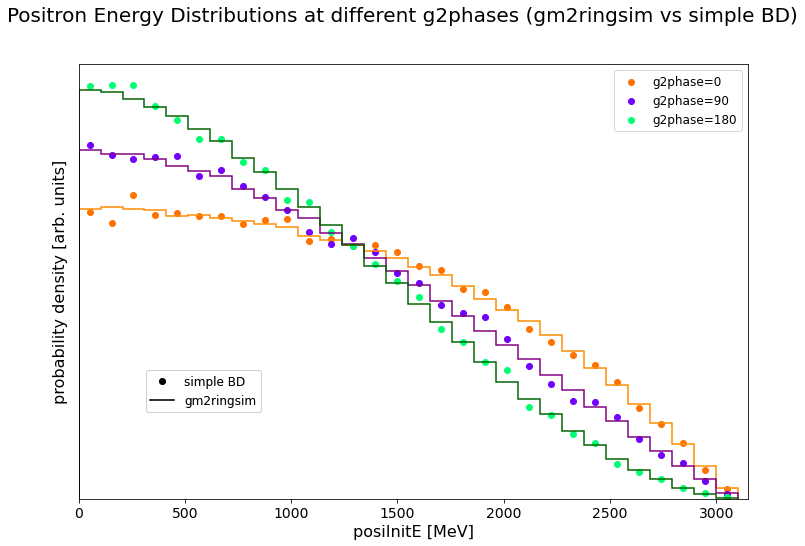

In [27]:
EvPhases(target_label='simple BD')

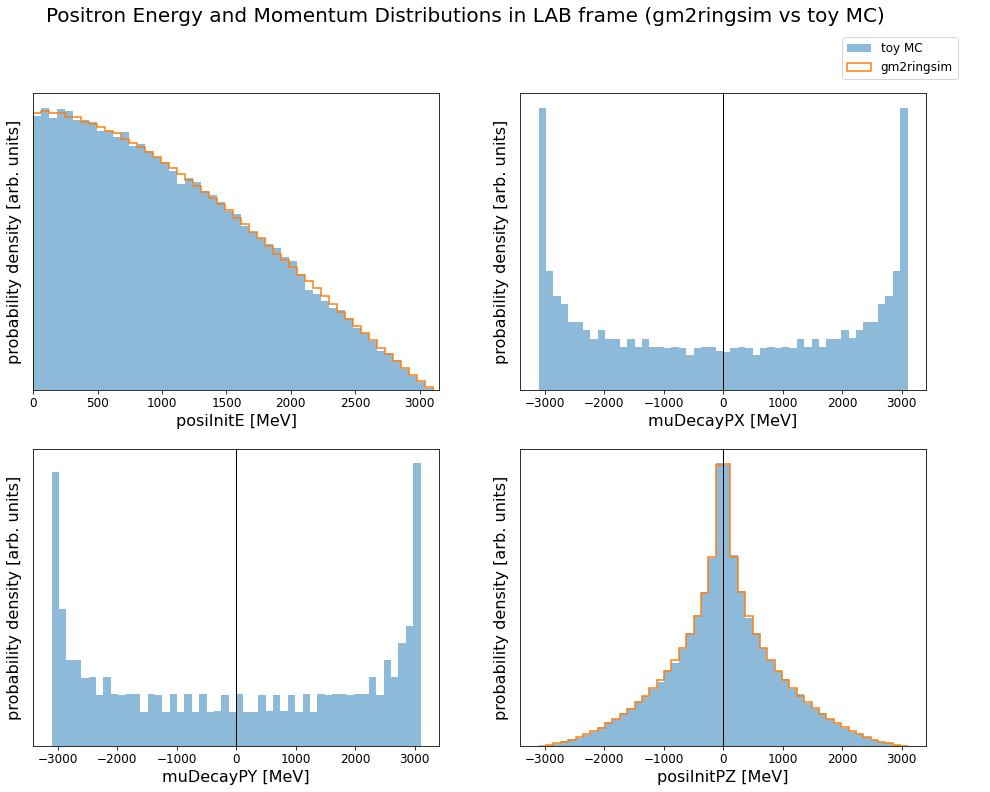

In [28]:
# make a plot to compare with the toy MC data
fig = plt.figure(figsize=(16,12))
fig.suptitle('Positron Energy and Momentum Distributions in LAB frame (gm2ringsim vs toy MC)', fontsize=20)

# store the following final variables
#     four_momenta_LAB[i,0] = PosiInitE
#     four_momenta_LAB[i,1] = PosiInitPX
#     four_momenta_LAB[i,2] = PosiInitPY
#     four_momenta_LAB[i,3] = PosiInitPZ
#     four_momenta_LAB[i,4] = beta_mu_x # related to muDecayPX
#     four_momenta_LAB[i,5] = beta_mu_z # related to muDecayPZ
#     four_momenta_LAB[:,6] = four_momenta_mu_frame[:,4] # muDecayPolX
#     four_momenta_LAB[:,7] = four_momenta_mu_frame[:,5] # muDecayPolZ  
#     four_momenta_LAB[i,8] = phase # g2phase
#     four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  
ax1 = fig.add_subplot(2,2,1)
ax1.hist(four_momenta_LAB[:,0],range=(0,3100),bins=50,density=True,alpha=0.5,label='toy MC')
ax1.hist(data_gm2ringsim['posiInitE'],range=(0,3100),density=True,bins=50,histtype='step',linewidth=1.5,label='gm2ringsim')
ax1.set_xlim([0,3150])
ax1.set_xlabel('posiInitE [MeV]',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', left=False)
ax1.set_yticklabels([])

ax2 = fig.add_subplot(2,2,2)
ax2.hist(four_momenta_LAB[:,4],range=(-3100,3100),bins=50,density=True,alpha=0.5)
# ax2.hist(data_gm2ringsim['posiInitPX'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax2.axvline(color='black', lw=1.0)
ax2.set_xlabel('muDecayPX [MeV]',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', left=False)
ax2.set_yticklabels([])

ax3 = fig.add_subplot(2,2,3)
ax3.hist(four_momenta_LAB[:,5],range=(-3100,3100),bins=50,density=True,alpha=0.5)
# ax3.hist(data_gm2ringsim['posiInitPY'],range=(-56,56),bins=50,density=True,histtype='step',linewidth=1.5)
ax3.axvline(color='black', lw=1.0)
ax3.set_xlabel('muDecayPY [MeV]',fontsize=16)
ax3.set_ylabel("probability density [arb. units]",fontsize=16)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', left=False)
ax3.set_yticklabels([])

ax4 = fig.add_subplot(2,2,4)
ax4.hist(four_momenta_LAB[:,3],range=(-3100,3100),bins=50,density=True,alpha=0.5)
ax4.hist(data_gm2ringsim['posiInitPZ'],range=(-3100,3100),bins=50,density=True,histtype='step',linewidth=1.5)
ax4.axvline(color='black', lw=1.0)
ax4.set_xlabel('posiInitPZ [MeV]',fontsize=16)
ax4.set_ylabel("probability density [arb. units]",fontsize=16)
ax4.tick_params(axis='x', labelsize=12)
ax4.tick_params(axis='y', left=False)
ax4.set_yticklabels([])


fig.legend(loc=(0.85,0.9),fontsize=12)

# Parallelization test

In [4]:
# for more complete bd, pls go to
# https://cdcvs.fnal.gov/redmine/projects/gm2ringsim/repository/revisions/develop/entry/actions/PGA/GasGunBdyn/GasGunBdyn_service.cc
# cyclotron period 0.2291 MHz (149.2 ns ~ 0.1 us)
# spin precession frequency = 6.9315 MHz (0.1443 us)
# data from E989 Note 205: The Beam Dynamics Model (Sweigart)

get_theta_c = lambda t:2*np.pi/0.1492*t # cyclotron motion, phase set to 0
get_theta_s = lambda t:2*np.pi/0.1443*t # spin precession, phase set to 0

N_pts = int(700/0.1)

cyclotron_angles = get_theta_c(np.arange(N_pts))
precession_angles = get_theta_s(np.arange(N_pts))

In [14]:
def GenerateFill():    
    four_momenta_LAB = np.zeros(shape=(N_pts,10))
    for i in range(N_pts):
        # positrons in MRF
        theta_s = precession_angles[i]
        E_primed, px_primed, py_primed, pz_primed, muDecayPolX, muDecayPolZ = GeneratePositron_MRF(*GenerateMichelKinematics(),theta_s)
        
        # boost to LAB frame
        theta_c = cyclotron_angles[i]
        four_momenta_LAB[i,0:6] = GeneratePositron_LAB(E_primed, px_primed, py_primed, pz_primed, theta_c)
        four_momenta_LAB[:,6] = muDecayPolX
        four_momenta_LAB[:,7] = muDecayPolZ  

        # calculate and store g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
        phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,5],
                                four_momenta_LAB[i,6], four_momenta_LAB[i,7])
        four_momenta_LAB[i,8] = phase # g2phase
        four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  
    
    return four_momenta_LAB

In [20]:
from multiprocessing import Pool  
pool = Pool(processes=4)
# pool.map(GenerateFill(), range(5))
fills = pool.starmap(GenerateFill, [() for i in range(20)])
pool.close()
pool.join()

# collect all the fills together
four_momenta_LAB = fills[0]
for i in range(len(fills)-1):
    four_momenta_LAB = np.concatenate((four_momenta_LAB,fills[i+1]))

In [ ]:
import ROOT as r
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load MC data
Michel_Samples = np.load('./data/01_michel_samples_10M.npy') # MAX_LOOP=Michel_Samples.shape[0]
four_momenta_mu_frame = np.load('./data/02_four_momenta_MRF_10M.npy')
four_momenta_LAB = np.load('./data/03_four_momenta_LAB_10M.npy')

In [ ]:
# theoretical calculation, integrated over cos(theta)
x1 = np.zeros(shape=(2,100))
x1[0]=np.linspace(0.0,1.0,100)

y1 = lambda x:(3-2*x)*x*x # IntroductoryMuonScience-Nagamine p.12
x1[1] = y1(x1[0])
x1[1] = x1[1]/np.mean(x1[1]) # dividing a distribution with its mean is p.d.f

# theoretical calculation, integrated over x
x2 = np.zeros(shape=(2,100))
x2[0]=np.linspace(-1.0,1.0,100)

y2 = lambda x:1 + x/3
x2[1] = y2(x2[0])
# x2[1] = x2[1]/np.mean(x2[1]) # dividing a distribution with its mean is p.d.f

In [ ]:
plt.rcParams['text.usetex'] = False # enable latex rendering
fig = plt.figure(figsize=(16,6))
fig.suptitle('Energy and Polar Angle Distribution of Positrons in the Sampled Michel Spectrum ', fontsize=20)

ax1 = fig.add_subplot(1,2,1)
ax1.hist(Michel_Samples[:,0],bins=50,density=True, stacked=True,label='sampled distribution') # density:normalized
ax1.plot(x1[0],x1[1],linewidth=2.5,label='theoretical distribution')
ax1.set_xlim([0,1])
ax1.set_yticklabels([])
ax1.set_xlabel('x',fontsize=16)
ax1.set_ylabel("probability density [arb. units]",fontsize=16)
ax1.tick_params(axis='y', left=False)
ax1.tick_params(axis='x', labelsize=12)
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(1,2,2)
ax2.hist(Michel_Samples[:,1],bins=50,density=True)
ax2.plot(x2[0],x2[1],linewidth=2.5,label='theoretical distribution')
ax2.set_xlim([-1,1])
# ax2.set_ylim([0.3,0.7])
ax2.set_yticklabels([])
ax2.set_xlabel('cos(theta)',fontsize=16)
ax2.set_ylabel("probability density [arb. units]",fontsize=16)
ax2.tick_params(axis='y', left=False)
ax2.tick_params(axis='x', labelsize=12)

fname = './data/fig1.1_michel_01zzz.png'
# plt.savefig(fname)